### Proximal policy optimization

PPO [1] is trying to combine the two objectives into one: first that $\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}$ is maximized and secondly that the policy does not go far from the original policy in the action distribution space by not encouraging it (clipping)

Having collected experience $D_k$ from policy $\pi_k$, compute rewards-to-go $\hat{R}$ and advantage estimates $A=Q(s,a)-V(s,a)=r_t+\gamma v_{t+1}-v_t$ using value estimates.

Next, update $\theta$ using Adam steps until $D_{KL}(\theta|\theta_k)>\delta$ on objective

$$
L_1(\theta)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}\min\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}A^{\pi_k}(s_t,a_t),g(\varepsilon,A^{\pi_k}(s_t,a_t))\right)
$$

Using a constraint $J_C+g_C(\theta-\theta_0)\leq С_{\max}$ with projection after each step

with $g(\varepsilon, A)=\begin{cases}
(1+\varepsilon)A,&A\geq 0\\
(1-\varepsilon)A,&A< 0\\
\end{cases}$

and on 
$$
L_2(\varphi)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}(V_\varphi(s_t)-\hat{R}_t)^2
$$


[1] https://spinningup.openai.com/en/latest/algorithms/ppo.html

In [1]:
#%load_ext autoreload
#%autoreload 2
from sppo import *
from baselines import *
from tf_helpers import *
from saferl import *
#from test_agents import *
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

### Training unsafe

In [2]:
R_thresh = 150
epochs = 5000

env = make_safe_env('CartPole-v0-left-half')
env.threshold = 80
sess = create_modest_session()
agent = ConstrainedProximalPolicyOptimization(
    env, sess, steps = 5, lr_policy = 1e-3, lr_value = 1e-3, ignore_constraint = True)
loop = ConstrainedEpisodicTrainLoop(env, agent, episodes_to_collect=15)
sess.run(tf.global_variables_initializer())

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfa

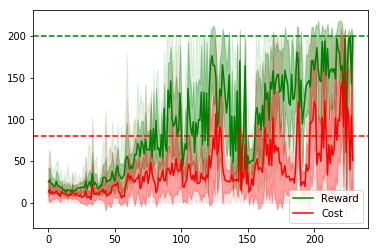

In [3]:
r = loop.achieve_reward(200, 1000, plot_every = 30)

### Training safe

In [19]:
R_thresh = 200
epochs = 10000

env = make_safe_env('CartPole-v0-left-half')
env.threshold = 100
sess = create_modest_session()
agent = ConstrainedProximalPolicyOptimization(
    env, sess, steps = 3, lr_policy = 1e-3, lr_value = 1e-3, lr_failsafe = 1e-3)
loop = ConstrainedEpisodicTrainLoop(env, agent, episodes_to_collect=30)
sess.run(tf.global_variables_initializer())

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfa

In [20]:
agent.track_metrics([
    #agent.t_delta_proj_len,
    #agent.t_R,
    #agent.t_R_clipped,
    tf.linalg.norm(agent.t_g_C_flat, name = 'constr_grad'),
                     tf.identity(50 * agent.t_RtoC, name = 'cos_sc'),
                    tf.identity(agent.t_using_safe * 100, name = 'safe')])

In [21]:
loop.train_step()

{'constr_grad/Squeeze': (0.8452484281308639,
  0.01739001257745912,
  0.8249158356748533,
  0.8673962964251556),
 'cos_sc': (-39.987434961917465,
  2.08292196454094,
  -42.24208930296721,
  -37.218387286148236),
 'safe': (100.0, 0.0, 100.0, 100.0),
 'Reward': (16.966666666666665, 6.789616254906376, 8.0, 43.0),
 'Cost': (9.7, 9.13655660884705, 0.0, 39.0)}

In [22]:
# RL algos can diverge after finding a solution
# https://www.reddit.com/r/MachineLearning/comments/8pcykb/d_actor_critic_ddpg_diverging_after_finding/
# Add KL-divergence check? (now missing...)

sess.run(tf.global_variables_initializer())

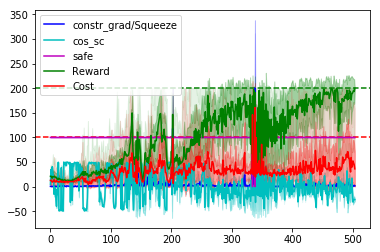

In [23]:
# train and hope...
r = loop.achieve_reward(R_thresh=R_thresh, max_epochs=epochs, plot_every=30)

In [ ]:
plt.hist([x['Cost'][0] for x in r])

In [14]:
for i, x in enumerate(r):
    print(i, x['sack_clipped:0'][2], x['Cost'][0], x['Reward'][0], x['proj_step/Squeeze:0'][0], x['cos_sc:0'][0])

0 9.866666666666667 21.666666666666668 -34.35832016108842
1 9.733333333333333 20.6 -40.879315034595905
2 9.4 21.066666666666666 -41.85159704539556
3 7.866666666666666 18.266666666666666 -33.55074507334941
4 14.2 29.8 -32.47040152165098
5 9.8 29.533333333333335 -44.41388508735612
6 7.466666666666667 19.133333333333333 -36.713499972319916
7 6.6 18.066666666666666 -48.30346317960057
8 10.333333333333334 20.266666666666666 -43.89020520008934
9 8.733333333333333 21.466666666666665 -48.105935115995365
10 7.733333333333333 23.066666666666666 -39.44621581246413
11 8.4 22.333333333333332 -45.21029237380077
12 8.133333333333333 18.533333333333335 -46.942115929458254
13 5.666666666666667 18.533333333333335 -45.79015406932713
14 6.4 17.266666666666666 -47.72489402239689
15 7.666666666666667 19.066666666666666 -49.40703580755396
16 5.533333333333333 14.733333333333333 -47.66017290468246
17 5.733333333333333 18.4 -43.561615665212074
18 5.2 15.4 -22.826222748706407
19 5.4 16.866666666666667 35.245339

1. Now have an overflow somewhere (invalid value in less), increased eps. Trying to analyze...


2. Switched to SGD (maybe adam is too agressive)?
3. Estimating constraint return properly, not nly for the first episode but the mean. Mistake in constraint estimation... The moment it goes slightly above the constraint, it plummets down.
4. Next step: monitor why it stops when _reward_ reaches the threshold and not constraint. It just resets and kills the performance... Monitor a) cos b) distance to the set c) returns d) distance projected - original
5. Removed the step where I compute modified R after GD step. Problem is that delta J is too high and the step is equivalent to a large GD step
6. Added failsafe solution. Goes down even with failsafe solution...Removed proj. ops -> no down, added proj. ops (not running) -> no down. With proj and 0 GD failsafe:fails. TF always assigns both in cond() if operations are created before... switched to lambdas, now no divergence!
7. NO failsafe -> reward goes to 0 on violation (too high)
8. with failsafe obtains ~ 125 with little violations. Trying to do 5 + thresh for failsafe -> diverges for Cmax = 20
9. Replaced act to sigmoid so that layers are better used

Want: $(\theta_1+\Delta\theta-\theta_0)^T g_C\leq C_{\max}$ which gives $\Delta\theta^T g_C\leq C_{\max}-J_C+(\theta_0-\theta_1)^T g_C=R$. In case if $R>0$, no action required. Otherwise $\Delta\theta=g_CR/\|g_C\|^2$

1. Slow convergence. Try to increase step size if $\cos (g_R, g_C)$ is approximately $1$? Measure it and check!
2. Estimate $g_C$ over many episodes to get a more reliable constraint

In [ ]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

In [ ]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')